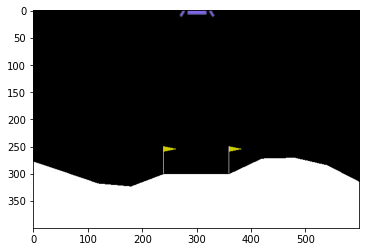

In [1]:
import gym
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from collections import deque
import numpy as np
%matplotlib inline

env = gym.make('LunarLander-v2')
env.reset()
plt.imshow(env.render(mode="rgb_array"));

In [2]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    
    def __len__(self):
        return len(self.buffer)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                 size=batch_size,
                                 replace=False)
        return [self.buffer[i] for i in index]
    
    def get_all(self):
        return [self.buffer[i] for i in range(len(self.buffer))]

In [50]:
class ActorCritic(tf.keras.Model):
    def __init__(self, env, training=True):
        super(ActorCritic, self).__init__()
        
        self.inputs = layers.Input(shape=(8,))
        self.fc1 = layers.Dense(50, activation="relu")
        self.fc2 = layers.Dense(50, activation="relu")
        self.actor = layers.Dense(4, activation="linear")
        self.critic = layers.Dense(1, activation="linear")
        
        self.env = env
        
        self.training = training
        self.opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(inputs)
        actions = self.actor(x)
        value = self.critic(x)
        return actions, value
    
    def select_action(self, inputs, episode):
        
        max_epsilon = 0.5             # Exploration probability at start
        min_epsilon = 0            # Minimum exploration probability 
        decay_rate = 0.003          # Exponential decay rate for exploration prob
        
        # random number for explore/exploit trade-off
        epsilon = np.random.rand()

        # current ee prob
        explore_prob = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*episode)
        
        action_logits, value = self.call(tf.expand_dims(inputs, axis=0))
        
        # choose random action or max action_probs, epsilon greedy
        if epsilon < explore_prob and self.training:
            action = self.env.action_space.sample()
        
        else:
            action = tf.random.categorical(action_logits, 1)[0, 0].numpy()
        
        return action, tf.nn.softmax(action_logits), value
    
    def train_step(self, state, episode):
        
        action, action_probs, value = self.select_action(state, episode)
        next_state, reward, done, _ = self.env.step(action)
        log_action = tf.math.log(tf.squeeze(action_probs)[action])
        
        return action, log_action, value, next_state, reward, done
        
        
    def learn(self, rewards, log_actions, values, Vt):
        
        with tf.GradientTape() as tape:
            
            # update value estimates
            for t in reversed(range(len(rewards)+1)):
                Vt = rewards[t] + (gamma * Vt)
                Vs = Vs.write(t, Vt)

            Vs = Vs.stack()
            Vs = (Vs - tf.math.reduce_mean(Vs)) / (tf.math.reduce_std(Vs) + 1e-9)

            actor_loss = -tf.math.reduce_sum(log_actions * (Vs-values))
            critic_loss = tf.keras.losses.Huber()(tf.squeeze(values), Vs)
            loss = actor_loss + critic_loss

        grads = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.trainable_variables))
        
        return loss
    
    
    def train(self, episodes, max_steps=200):
        episode_reward_hist = np.zeros(episodes)
        loss_hist = []

        for episode in range(episodes):          
            
            step = 0
            state = self.env.reset()
            done = False
            episode_reward = 0
            
            rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
            log_actions = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
            values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
            Vs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
            
            while not done and step < max_steps:
                
                action, log_action, value, next_state, reward, done = self.train_step(state, episode)
                
                rewards = rewards.write(step, reward)
                log_actions = log_actions.write(step, log_action)
                values = values.write(step, value)

                episode_reward += reward
                step +=1
        
            rewards = rewards.stack()
            log_actions = log_actions.stack()
            values = values.stack()
            Vt = tf.constant(0.0)
            
            loss = self.learn(rewards, log_actions, values, Vt)
            loss_hist.append(loss)
            episode_reward_hist[episode] = episode_reward
            
            if episode % 1 == 0:
                print(f"Episode:{episode}, Loss: {(actor_loss.numpy(), critic_loss.numpy())}, Ep reward:{episode_reward}")

In [51]:
ac = ActorCritic(env)
ac.train(1)

InvalidArgumentError: slice index 141 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

NameError: name 'action_prob' is not defined

In [17]:
env.reset()

array([-0.00380335,  1.4052917 , -0.38524708, -0.25016204,  0.00441386,
        0.08726414,  0.        ,  0.        ], dtype=float32)